# NLP Classifer: Twitter Sentiment on Apple and Google Products (Phase 4 Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time: 05.22.2023
* Instructor name: Morgan Jones
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:



## Overview and Business Understanding/Questions



## Data Source and Exploration



This data comes from Data World at the following site: https://data.world/crowdflower/brands-and-product-emotions
Tweets regarding Google and Apple product were collected and contributors evaluated the tweets as containing positive, negative, or neutral content.

All features in the dataset were used. These were:
tweet_text

emotion_in_tweet_is_directed_at

is_there_an_emotion_directed_at_a_brand_or_product

There was some sort of error in the downloaded file that prevented accurate formatting.  I used Excel as an intermediary to import, edit, and then export the csv file again to fix the formatting issue. 

In [128]:
import pandas as pd

In [129]:
df = pd.read_csv('tweets.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,NaN
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,NaN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,NaN,NaN


It seems that additional columns were created in my editing of the file's formatting.  These Unnamed columns are superfluous, so I will remove them. 

The useful features are also a little wordy. Out of convenience, I'm going to simplify these column names. 

In [130]:
df = df.drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)
df = df.rename(columns={'tweet_text': 'tweets', 
                        'emotion_in_tweet_is_directed_at': 'company', 
                        'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})

In [131]:
df.head()

,tweets,company,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   9261 non-null   object
 1   company  3306 non-null   object
 2   emotion  9081 non-null   object
dtypes: object(3)
memory usage: 217.2+ KB


It looks like we're missing quite a few values for the company, and 180 values for emotion.  For the purposes of this classifer model, it may not be necessary to have all rows contain company information, so I will leave that for now.  However, the emotion class is essential, so let's take a look at what's happening there. 

In [133]:
df.emotion.value_counts()

No emotion toward brand or product      5374
Positive emotion                        2976
Negative emotion                         570
I can't tell                             156
 USA                                       1
 Andro... {link} #sxsw #music #news"       1
iPad                                       1
 Android                                   1
 Texas                                     1
Name: emotion, dtype: int64

It seems that there are a few entries that have been mislabeled, perhaps shifted into an inappropriate column.  Since there are so few of these in comparison with the rest of the data, I am simply going to delete these mislabeled rows.

There are also 156 containing the string "I can't tell."  This will probably not be useful for our purposes, so I'm going to go ahead and delete these. 

In [134]:
index_names = df[(df['emotion'] != 'No emotion toward brand or product') &
                (df['emotion'] != 'Positive emotion') &
                (df['emotion'] != 'Negative emotion')].index
df.drop(index_names, inplace = True)

In [135]:
df.emotion.value_counts()

No emotion toward brand or product    5374
Positive emotion                      2976
Negative emotion                       570
Name: emotion, dtype: int64

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8920 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   8920 non-null   object
 1   company  3280 non-null   object
 2   emotion  8920 non-null   object
dtypes: object(3)
memory usage: 278.8+ KB


Great, so now our three classes make sense and all null or useless values have been removed. 

In [137]:
df.company.value_counts()

iPad                               941
Apple                              659
iPad or iPhone App                 469
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: company, dtype: int64

The labels are subdivided within the larger categories of Apple or Google.  While I am not sure the distinction between "iPad," "iPad or iPhone App," and "iPhone," it is possible that the model will be better able to evaluate an emotion based on these subcategories (perhaps a label of 'iPhone' is more likely to be associated with a negative emotion, for example), so I will leave these as they are for now. 

Below I standardize the tweets so they are all lowercase

In [138]:
df.tweets = df.tweets.str.lower()
df.head()

,tweets,company,emotion
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion


I now need to tokenize the tweets.

In [139]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

df["tweets_tokenized"] = df["tweets"].apply(tokenizer.tokenize)

df.head()

,tweets,company,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


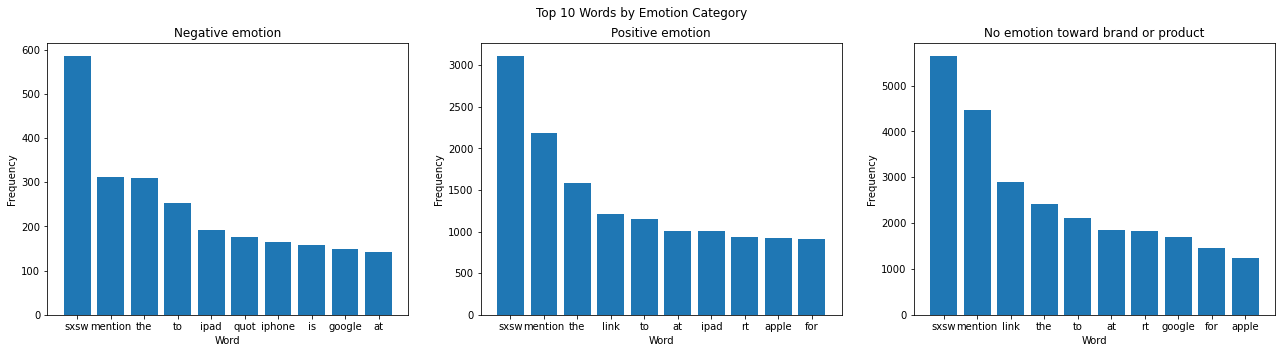

In [140]:
import nltk
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

def plot_frequency_by_emotion(dataframe):
    # Tokenizing words in the 'tweets_tokenized' column and creating a list of all tokens
    all_tokens = [token for tweet in df['tweets_tokenized'] for token in tweet]

    # Calculating frequency distribution for all tokens
    all_tokens_freq = FreqDist(all_tokens)

    # Setting up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22,5))

    # Plotting frequency distribution for each category
    for index, emotion in enumerate(df['emotion'].unique()):
        # Filtering dataframe by emotion category and tokenizing words
        category_tokens = [token for tweet in df[df['emotion'] == emotion]['tweets_tokenized'] for token in tweet]

        # Calculating frequency distribution for this category
        category_tokens_freq = FreqDist(category_tokens)

        # Getting top 10 most common tokens and their counts
        top_10_tokens = [token[0] for token in category_tokens_freq.most_common(10)]
        top_10_counts = [token[1] for token in category_tokens_freq.most_common(10)]

        # Plotting bar chart of top 10 tokens and their counts
        ax = axes[index]
        ax.bar(top_10_tokens, top_10_counts)
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    plt.suptitle('Top 10 Words by Emotion Category')
    plt.show()

plot_frequency_by_emotion(df)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['emotion'], axis=1)
y = df.emotion
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
baseline_model = MultinomialNB()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

In [141]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

In [142]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [143]:
df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)

In [144]:
df.head()

,tweets,company,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


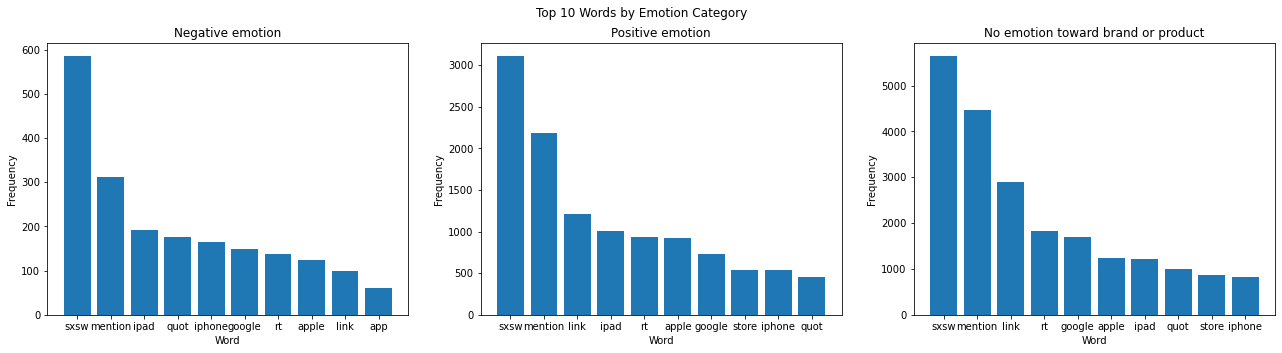

In [145]:
plot_frequency_by_emotion(df)

So the stopwords have been removed, great!  There still seems to be significant overlap between the words in each category, for example the words sxsw, mention, ipad, apple, iphone, google, link, rt, and quot are found in all three, and 'store' is found in two out of the three.  Since these terms are so common among all three, they may not be particularly useful for the model to distiguish between these three categories, so I may remove them down the line depending on the accuracy of the model.  

In [146]:
# print("Original list length:", len(stopwords_list))
# new_words = ['sxsw', 'mention', 'ipad', 'quot', 'iphone', 'google', 'rt', 'apple', 'link', 'quot']
# stopwords_list.extend(new_words)
# print("List length after adding 'for':", len(stopwords_list))

In [147]:
# df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)
# plot_frequency_by_emotion(df)

In [148]:
from sklearn.model_selection import train_test_split

X = df.drop(['emotion'], axis=1)
y = df.emotion
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list)

# Convert list of tokens to a string
train_text = [' '.join(tokens) for tokens in X_train["tweets_tokenized"]]

# Fit the vectorizer on train_text and transform it
X_train_vectorized = tfidf.fit_transform(train_text)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())


,apple,google,ipad,iphone,link,mention,quot,rt,store,sxsw
0,0.000000,0.000000,0.000000,0.0,0.518766,0.474401,0.0,0.648434,0.000000,0.292161
1,0.000000,0.000000,0.000000,0.0,0.871320,0.000000,0.0,0.000000,0.000000,0.490714
2,0.000000,0.000000,0.751484,0.0,0.574855,0.000000,0.0,0.000000,0.000000,0.323749
3,0.000000,0.000000,0.000000,0.0,0.518766,0.474401,0.0,0.648434,0.000000,0.292161
4,0.000000,0.000000,0.757576,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.652748
...,...,...,...,...,...,...,...,...,...,...
7131,0.000000,0.619640,0.000000,0.0,0.000000,0.435541,0.0,0.595318,0.000000,0.268229
7132,0.000000,0.462376,0.000000,0.0,0.355395,0.650003,0.0,0.444227,0.000000,0.200153
7133,0.000000,0.000000,0.375579,0.0,0.287302,0.788197,0.0,0.359115,0.000000,0.161804
7134,0.694545,0.000000,0.660741,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.284656


In [155]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
baseline_model = MultinomialNB()
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv

array([0.60364146, 0.60406447, 0.60406447, 0.6033637 , 0.6033637 ])

In [158]:
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.6036995597117614
Stopwords removed: 0.6036995597117614


## Importing, Previewing, and Exploring Data


## Manipulating the Data

## Conclusion and Recommendation